# Label analysis

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import seaborn as sns
import metalabeller as ml
import ta
import macdtester as t

In [25]:
df = dl.get_working_data("ATOMUSDT", span="m")

In [2]:
df = dl.get_working_data("ATOMUSDT", span="h")

In [3]:
df["trend"] = df.close.rolling(500).mean()
df.dropna(inplace=True)

In [4]:
df.tail(3)

,open,high,low,close,volume,trend
timestamp,,,,,,
2021-11-09 22:00:00,35.99,36.08,35.75,36.07,33370.53,36.71066
2021-11-09 23:00:00,36.08,36.15,35.64,35.84,47171.96,36.71510
2021-11-10 00:00:00,35.83,36.06,35.76,35.89,27237.24,36.71924


## Bars
- size of bars
- closing relatives of bars
- size of bars compared to past bars
- std of bars compared to past bars

### Size of bars

In [637]:
base = t.get_base_macd_events(df, mlen=3, stdev=1)

In [638]:
# stats = ["bar_std", "bar_std1", "bar_std2", "bstd_7std", "h_impulse", "greens"]
stats = ["crm", "crm_compare", "cp", "ht", "ht_std"]

In [486]:
# def bar_std(df, df1=None, df7=None, df30=None):
#     heights = df.high-df.low
#     return np.std(heights)
# def bar_std1(df, df1, df7=None, df30=None):
#     heights = df1.high-df1.low
#     return np.std(heights)
# def bar_std2(df, df1, df7, df30=None):
#     heights = df7.high-df7.low
#     return np.std(heights)

# def bar_std_compare(df, df1, df7, df30):
#     base = bar_std(df)
#     new = bar_std(df7)
#     return base/new

# def h_impulse(df, df1, df7, df30):
#     """height of inpulse before max macd divided by average height"""
#     i = df.macd.idxmax()
#     h1 = np.mean(df[:i].high - df[:i].low)
#     return h1/(np.mean(df7.high-df7.low))

    
# def greens(df, df1, df7, df30):
#     greens = len(df[df.close>df.open])
#     return greens/(len(df))

In [639]:
def crm(df, df1, df7, df30):
    """close relative to midpoint"""
    mp = (df.high-df.low)*0.5+df.low
    return np.mean(df.close-mp)
def crm_compare(df, df1, df7, df30):
    """crm compare"""
    i = df.macd.idxmax()
    h1 = crm(df.loc[:i], df1, df7, df30)
    h2 = crm(df.loc[i:], df1, df7, df30)
    return h2
def cp(df, df1, df7, df30):
    return (df.iloc[-1].close-df.iloc[0].open)/(max(df.high)-df.iloc[0].open)

def ht(df, df1, df7, df30):
    i = df.macd.idxmax()
    h = df.loc[:i].high-df.loc[:i].low
    return np.mean(h)/df.iloc[0].open

def ht_std(df, df1, df7, df30):
    i = df.macd.idxmax()
    h = df.loc[:i].high-df.loc[:i].low
    return np.std(h)/df.iloc[0].open

In [640]:
# funcs = [bar_std, bar_std1, bar_std2, bar_std_compare, h_impulse, greens]
funcs = [crm, crm_compare, cp, ht, ht_std]

In [641]:
events = t.get_macd_events(df, base, stats, funcs)

In [642]:
events.tail()

,crm,crm_compare,cp,ht,ht_std
t0,,,,,
2021-10-09 22:00:00,0.103158,0.098000,0.898844,0.015929,0.005077
2021-10-14 01:00:00,0.258500,-0.026429,0.750000,0.065480,0.017005
2021-10-16 03:00:00,0.144615,0.076429,0.752665,0.028436,0.011836
2021-10-22 11:00:00,0.045000,0.092143,0.928571,0.017790,0.008081
2021-11-01 22:00:00,0.134000,0.085625,0.760494,0.029216,0.018301


In [643]:
labels = t.get_labels(df, events, 1, base.set_index("t0").gain.reindex(events.index), tp=2, sl=2, stats=False)

verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works


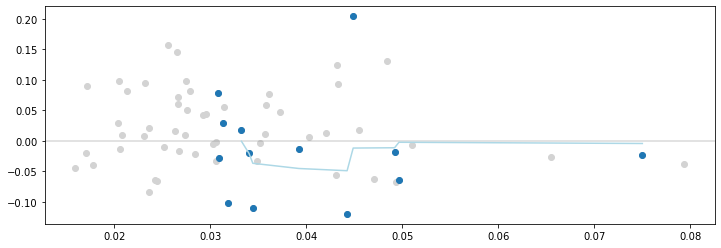

In [644]:
b = events[(events.cp>np.median(events.cp)) & (events.ht>np.median(events.ht)) & (events.ht_std>np.median(events.ht_std))]
x = b.ht
y = labels.reindex(b.index).ret
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x=events.ht, y=labels.ret, c="lightgray")
ax.scatter(x=x, y=y)
ax.axhline(0, c="gray", alpha=0.3)

ax.plot(average_line(x, y, 5), c="lightblue")

## MACD
- momentum divergence
- mean macd and compare
- std macd and compare
- downward momentum compared to upward momentum
- substantial macd move, check how many std above mean over past days

⭐
- md7, 1, 2, 2, atom 
- dm1, 1, 2, 2, atom
- std_move, 7, 2, 2, atom

In [5]:
base = t.get_base_macd_events(df, mlen=3, stdev=1)

In [6]:
stats = ["mean_macd", "std_macd", "md", "dm", "std_move"]

In [19]:
def mean_macd(df, df1, df7, df30):
#     return np.mean(df7.macd)/np.mean(df7.close)
    return np.mean(df7.macd)-np.mean(df30.macd)
def std_macd(df, df1, df7, df30):
    return np.std(df7.macd)/np.mean(df7.close)
def md(df, df1, df7, df30):
    cm = max(df.macd)
    pm = max(df7.loc[:df.index[0]].macd)
    return cm/(cm+pm)
def dm(df, df1, df7, df30):
    um = max(df.macd)
    dm = min(df1.macd)
    return um/(um+abs(dm))
def std_move(df, df1, df7, df30):
    u = max(df.macd)
    df_ = df30[df30.macd>0].loc[:df.index[0]]
    mean = np.mean(df_.macd)
    std = np.std(df_.macd)
    return (u-mean)/std

In [20]:
funcs = [mean_macd, std_macd, md, dm, std_move]

In [21]:
events = t.get_macd_events(df, base, stats, funcs)

In [22]:
labels = t.get_labels(df, events, 0.5, base.set_index("t0").gain.reindex(events.index), tp=1, sl=1, stats=False)


verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works


In [23]:
def average_line(x, y, ds):
    df = pd.Series(list(y), index=list(x)).sort_index()
    df = df.rolling(ds).mean() 
#     df.index -= abs((df.index[0]-df.dropna().index[0])*0.5)
    return df

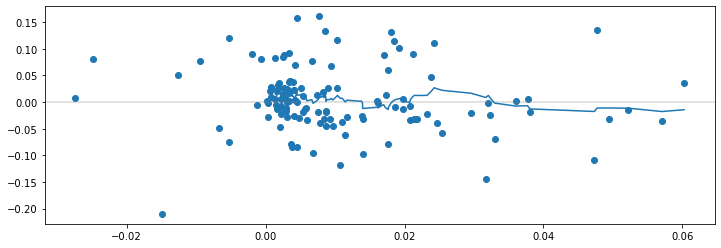

In [24]:
x = events.mean_macd
y = labels.ret
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x=x, y=y)
ax.axhline(0, c="gray", alpha=0.3)

ax.plot(average_line(x, y, 20))

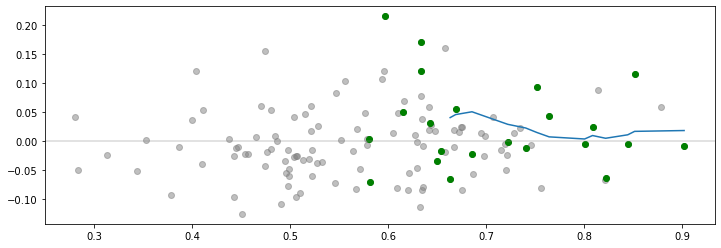

In [450]:
x = events[(events.md>0.5) & (events.dm>0.5) & (events.std_move>4)].dm
y = labels.reindex(events[(events.md>0.5) & (events.dm>0.5) & (events.std_move>4)].index).ret
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x=events.dm, y=labels.ret, c="gray", alpha=0.5)

ax.scatter(x=x, y=y, c="green")
ax.axhline(0, c="gray", alpha=0.3)

ax.plot(average_line(x, y, 10))


## Other indicators
- kelter channel band widths

## Price history
- mean change in moving average for past days (500)
- current moving average slope
- 

In [452]:
base = t.get_base_macd_events(df, mlen=3, stdev=1)

In [453]:
stats = ["trend", "trend7d", "trend30d"]

In [454]:
def trend(df, df1, df7, df30):
    return df.iloc[1].trend-df.iloc[0].trend
def trend7d(df, df1, df7, df30):
    return np.mean(df7.trend.diff())
def trend30d(df, df1, df7, df30):
    return np.mean(df30.trend.diff())

In [455]:
funcs = [trend, trend7d, trend30d]

In [456]:
events = t.get_macd_events(df, base, stats, funcs)

In [457]:
labels = t.get_labels(df, events, 1, base.set_index("t0").gain.reindex(events.index), tp=2, sl=2, stats=False)

verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works


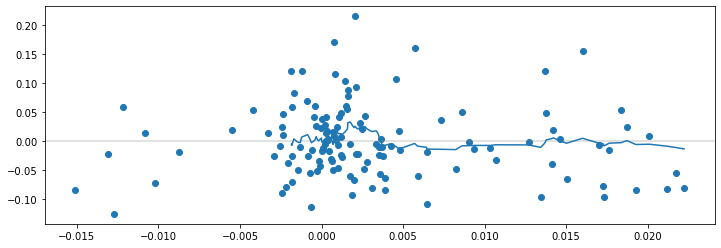

In [461]:
x = events.trend30d
y = labels.ret
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x=x, y=y)
ax.axhline(0, c="gray", alpha=0.3)

ax.plot(average_line(x, y, 20))

## BTC comparison
- compare mean hourly gains with mean of btc hourly gains

In [462]:
base = t.get_base_macd_events(df, mlen=3, stdev=1)
btc = dl.get_working_data("BTCUSDT", span="h")

In [463]:
stats = ["dif"]

In [481]:
def dif(df, df1, df7, df30, btc = btc):
    df7=df30
    btc_ = btc.reindex(df7.index)
    mc = (df7.iloc[-1].close-df7.iloc[0].open)/df7.iloc[0].open
    mc_btc = (btc_.iloc[-1].close-btc_.iloc[0].open)/btc_.iloc[0].open
    return mc-mc_btc

In [482]:
funcs = [dif]

In [483]:
events = t.get_macd_events(df, base, stats, funcs)

In [484]:
labels = t.get_labels(df, events, 1, base.set_index("t0").gain.reindex(events.index), tp=2, sl=2, stats=False)

verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works


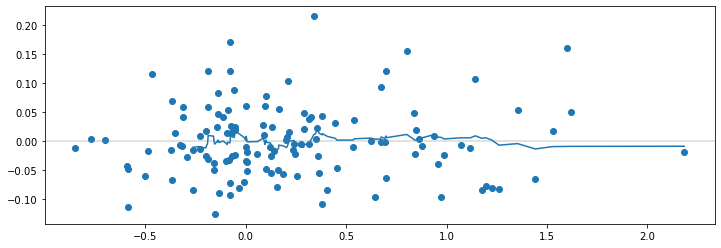

In [485]:
x = events.dif
y = labels.ret
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x=x, y=y)
ax.axhline(0, c="gray", alpha=0.3)

ax.plot(average_line(x, y, 20))